In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import cv2 as cv
from google.colab.patches import cv2_imshow as cv_imshow
from sklearn.model_selection import train_test_split
import random
from google.colab import drive
from tqdm import tqdm
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, BatchNormalization
from keras.models import Model
from keras import optimizers
from time import time

In [2]:
drive._mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/hand-segmentation/'
mask_folder = 'skin_masks'
img_folder = 'original_images'

In [4]:
# get the paths for segmented masks
mask_paths = []
for name in glob(path + mask_folder + '/*.bmp'):
  mask_paths.append(name)

# get the paths for images of hands
hand_paths = []
for name in glob(path + img_folder + '/*.jpg'):
  hand_paths.append(name)

In [5]:
# sort the names of paths to have corresponding masks and images
mask_paths.sort()
hand_paths.sort()
print(mask_paths[:5])
print(hand_paths[:5])
print(len(mask_paths))
print(len(hand_paths))

['/content/drive/MyDrive/hand-segmentation/skin_masks/1_P_hgr1_id01_1.bmp', '/content/drive/MyDrive/hand-segmentation/skin_masks/1_P_hgr1_id01_2.bmp', '/content/drive/MyDrive/hand-segmentation/skin_masks/1_P_hgr1_id01_3.bmp', '/content/drive/MyDrive/hand-segmentation/skin_masks/1_P_hgr1_id02_1.bmp', '/content/drive/MyDrive/hand-segmentation/skin_masks/1_P_hgr1_id02_2.bmp']
['/content/drive/MyDrive/hand-segmentation/original_images/1_P_hgr1_id01_1.jpg', '/content/drive/MyDrive/hand-segmentation/original_images/1_P_hgr1_id01_2.jpg', '/content/drive/MyDrive/hand-segmentation/original_images/1_P_hgr1_id01_3.jpg', '/content/drive/MyDrive/hand-segmentation/original_images/1_P_hgr1_id02_1.jpg', '/content/drive/MyDrive/hand-segmentation/original_images/1_P_hgr1_id02_2.jpg']
899
898


In [6]:
def get_file_name(file_path: str) -> str:
  name_ext = file_path.split('/')[-1]
  name = name_ext.split('.')[0]

  return name

In [7]:
mask_paths.pop(537)

'/content/drive/MyDrive/hand-segmentation/skin_masks/M_P_hgr1_id05_1.bmp'

In [8]:
for i in range(len(hand_paths)):
  mask_name = get_file_name(mask_paths[i])
  img_name = get_file_name(hand_paths[i])

  if mask_name != img_name:
    print(i, mask_name, img_name)

In [9]:
# read the images and masks stored in the found paths

hand_images = []
for path in tqdm(hand_paths):
  image = cv.imread(path)

  # convert from BGR to HSV colorspace for easier classification later
  image = cv.cvtColor(image,cv.COLOR_BGR2HSV)
  hand_images.append(image)

hand_masks = []
for path in tqdm(mask_paths):
  mask = cv.imread(path)
  hand_masks.append(mask)

100%|██████████| 898/898 [00:02<00:00, 334.50it/s]


In [10]:
print(hand_images[0].shape)
print(hand_masks[0].shape)

(422, 229, 3)
(422, 229, 3)


In [11]:
# convert the image and mask to float-arrays and normalise their values to be between 0 and 1

for i in tqdm(range(len(hand_images))):
  hand_images[i] = hand_images[i].astype('float32') / 255
  hand_masks[i] = hand_masks[i].astype('float32') / 255

100%|██████████| 898/898 [00:02<00:00, 387.78it/s]


<H1> Model 1: Logistic Regression

In [12]:
# flatten the images and masks for logistic regression classification

flat_images = []
flat_masks = []

for i in tqdm(range(len(hand_images))):
  flat_images.append(hand_images[i].reshape((-1, 3)))

  # converting the mask to a 0, 1 format for logistic regression
  new_mask = hand_masks[i].sum(axis=2) / 3

  # flip the 0 and 1s, so 1 is the existence of a hand and 0 otherwise
  new_mask = new_mask * -1 + 1

  flat_masks.append(new_mask.reshape((-1, 1)))

100%|██████████| 898/898 [00:04<00:00, 222.84it/s]


In [13]:
# check that the images still corresponf to each other

print(flat_images[5].shape)
print(flat_masks[5].shape)

(171915, 3)
(171915, 1)


In [14]:
# Concatenate all the data into two arrays for training
X = np.concatenate(flat_images[:200])
y = np.concatenate(flat_masks[:200])

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
# Build the logistic regression model
model_lr = LogisticRegression(verbose=True)
model_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.8s finished


LogisticRegression(verbose=True)

In [16]:
# Check accuracy metric
print(model_lr.score(X_train, y_train))
print(model_lr.score(X_test, y_test))

0.8987783618708513
0.8987748976722757


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


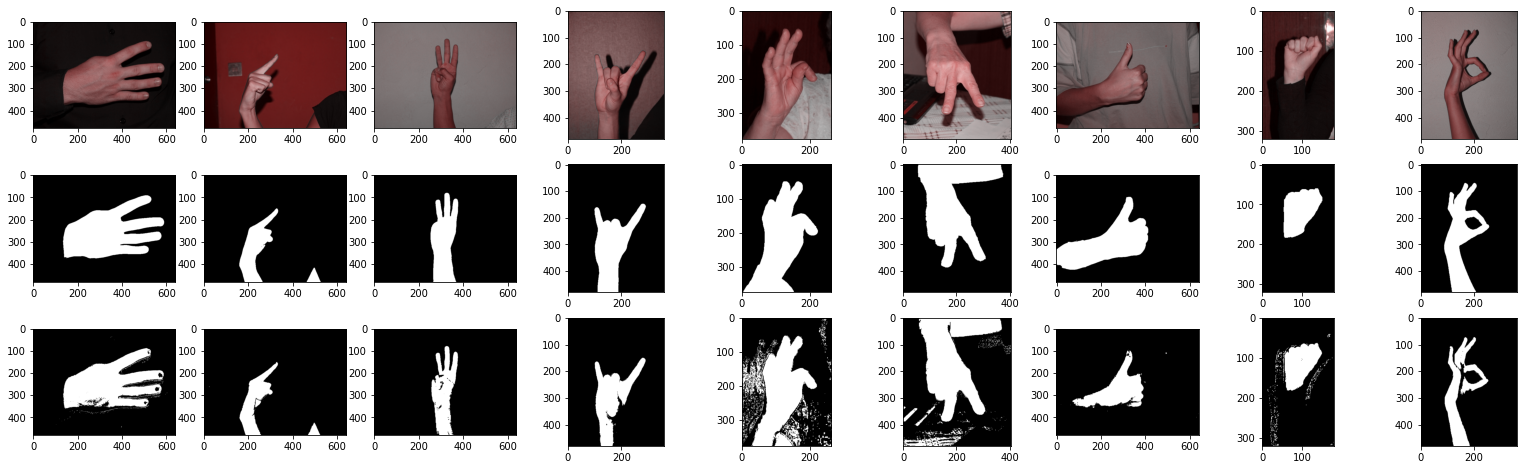

In [17]:
# Build a dashboard to see how the model performs on random examples

# Choose how many examples we want
k = 9

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=3, ncols=k, figsize=(3*k, 8))

# Cycle through a random selection of k images
for i, j in enumerate(random.sample(range(len(hand_images)), k)):

  example_img = hand_images[j]
  example_mask = hand_masks[j]

  # Pre-process the images to feed them to the Model
  flat_ex = example_img.reshape((-1, 3))

  # Feed the images through the model
  pred_mask_ex = (model_lr.predict_proba(flat_ex)[:, 1] > 0.6)

  # Reshape the output back to a 2-D image format
  pred_mask_ex = pred_mask_ex.reshape(example_img.shape[:2])

  # Show the original image, predicted map and ground truth map
  ax[0, i].imshow(cv.cvtColor(example_img,cv.COLOR_HSV2RGB))
  ax[1, i].imshow((-1*example_mask+1)*255)
  ax[2, i].imshow(pred_mask_ex*255, cmap='gray')

<H1> Models 2, 3: Various CNN Architectures

In [18]:
# Resize all images to a standard size to make the data more appropriate for a CNN architecture

res_images = []
res_masks = []

new_size = (128, 128)

for i in range(len(hand_images)):

  res_images.append(cv.resize(hand_images[i], new_size))

  res_masks.append(cv.resize(hand_masks[i], new_size))

In [19]:
del hand_images
del hand_masks

In [20]:
X = np.array(res_images)
y = np.array(res_masks)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
from skimage.transform import rotate

X_train_rot = []
y_train_rot = []

for i in tqdm(range(len(X_train))):
  theta = random.randint(0, 359)

  X_train_rot.append(rotate(X_train[i], angle=theta))
  y_train_rot.append(rotate(y_train[i], angle=theta))

X_train_rot = np.array(X_train_rot)
y_train_rot = np.array(y_train_rot)

100%|██████████| 601/601 [00:01<00:00, 320.36it/s]


In [22]:
X_train = np.concatenate([X_train, X_train_rot])
y_train = np.concatenate([y_train, y_train_rot])

In [23]:
del X_train_rot
del y_train_rot

<H2> Model 2: Autoencoder CNN Architecture

In [24]:
batch_size = 32
epochs = 50
inChannel = 3
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #64 x 64 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #32 x 32 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #32 x 32 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #16 x 16 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #16 x 16 x 128 (small and thick)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #8 x 8 x 128
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #8 x 8 x 256 (small and thick)

    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #8 x 8 x 256
    up1 = UpSampling2D((2,2))(conv5) #16 x 16 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) #16 x 16 x 64
    up2 = UpSampling2D((2,2))(conv6) #32 x 32 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2) #32 x 32 x 32
    up3 = UpSampling2D((2,2))(conv7) #64 x 64 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) # 64 x 64 x 1
    
    return decoded

In [25]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = optimizers.rmsprop_v2.RMSprop())

In [26]:
autoencoder_train = autoencoder.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Epoch 1/50
38/38 [==============================] - 19s 75ms/step - loss: 0.1803 - val_loss: 0.0791
Epoch 2/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0868 - val_loss: 0.0458
Epoch 3/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0558 - val_loss: 0.0569
Epoch 4/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0466 - val_loss: 0.0419
Epoch 5/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0408 - val_loss: 0.0306
Epoch 6/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0321 - val_loss: 0.0306
Epoch 7/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0302 - val_loss: 0.0270
Epoch 8/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0240 - val_loss: 0.0241
Epoch 9/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0220 - val_loss: 0.0266
Epoch 10/50
38/38 [==============================] - 2s 43ms/step - loss: 0.0218 - val_loss: 0.0161
Epoch 11

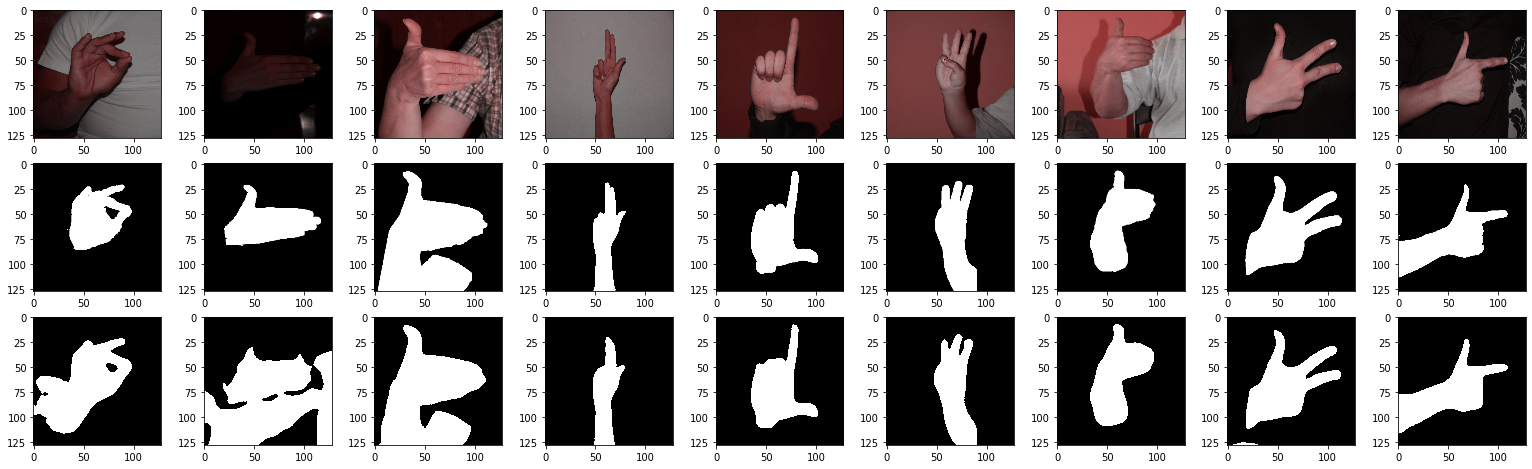

In [27]:
# Build a dashboard to see how the model performs on random examples

# Choose how many examples we want
k = 9

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=3, ncols=k, figsize=(3*k, 8))

sample = random.sample(range(len(y_test)), k)

preds = -1 * autoencoder.predict(X_test[sample]) + 1

# Cycle through a random selection of k images
for i, j in enumerate(sample):

  example_img = X_test[j]
  example_mask = y_test[j]

  # Feed the images through the model
  pred_mask_ex = (preds[i] > 0.4)

  # Reshape the output back to a 2-D image format
  pred_mask_ex = pred_mask_ex.reshape((128, 128))

  # Show the original image, predicted map and ground truth map
  ax[0, i].imshow(cv.cvtColor(example_img,cv.COLOR_HSV2RGB))
  ax[1, i].imshow((-1*example_mask+1))
  ax[2, i].imshow(pred_mask_ex, cmap='gray')

In [28]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856 

<H2> Model 3: U-NET CNN Architecture

In [29]:
# Set up hyperparameters

batch_size = 32
epochs = 50
inChannel = 3
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))

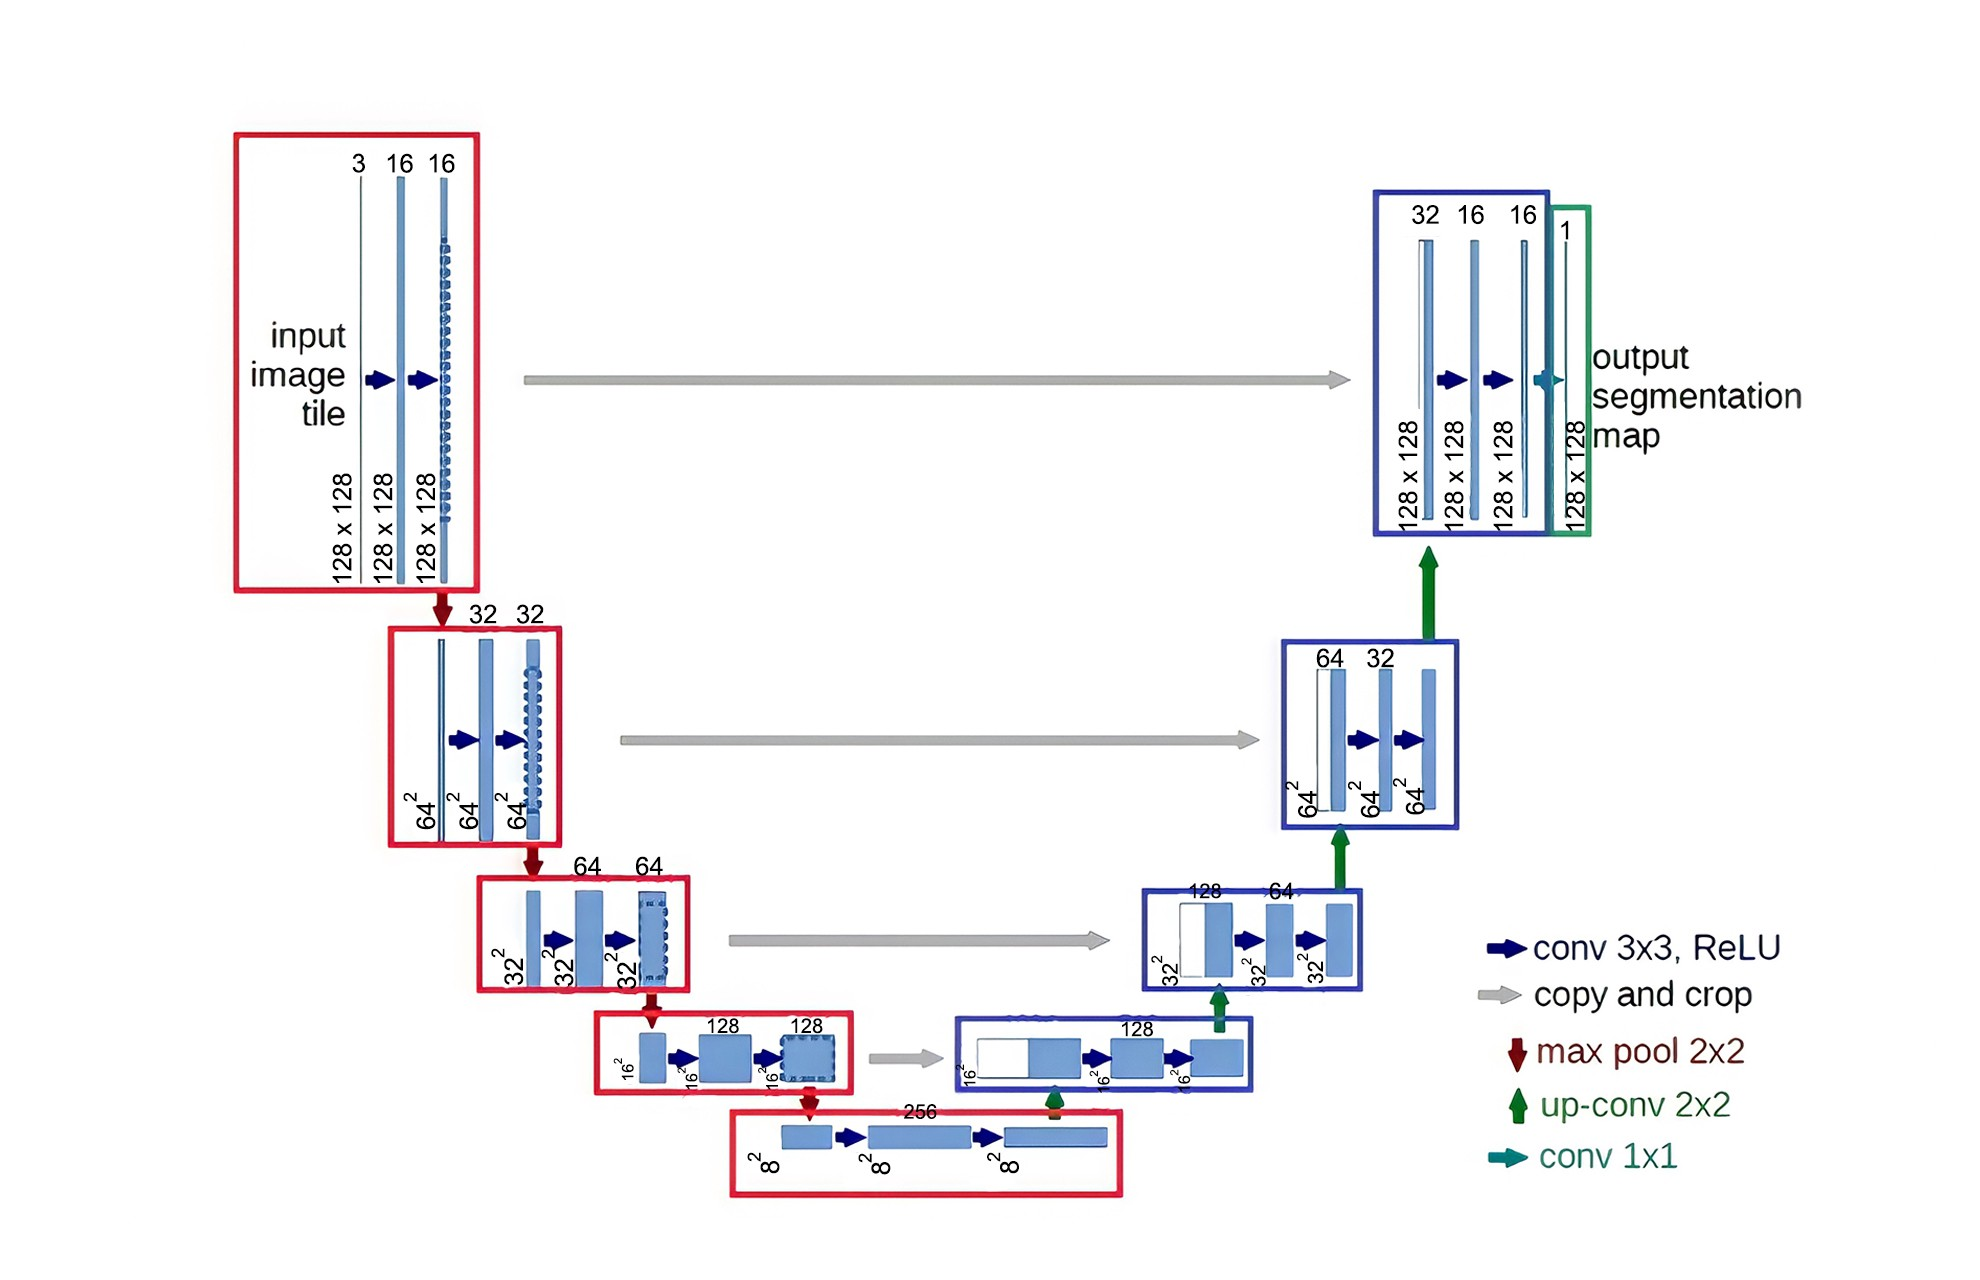

In [30]:
def unet(input_img):

  # First block Going down
  d1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  d1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(d1_2)

  # Second block Going down
  d2_1 = MaxPooling2D()(d1_3)
  d2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_1)
  d2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_2)

  # Third block Going down
  d3_1 = MaxPooling2D()(d2_3)
  d3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_1)
  d3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_2)

  # Fourth block Going down
  d4_1 = MaxPooling2D()(d3_3)
  d4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_1)
  d4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_2)

  # Fifth block 
  d5_1 = MaxPooling2D()(d4_3)
  d5_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_1)
  d5_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_2)

  # Fourth block going up, concatenated with Fourth block going down
  up4_0 = UpSampling2D((2, 2))(d5_3)
  up4_1 = tf.keras.layers.concatenate([d4_3, up4_0])
  up4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_1)
  up4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_2)

  # Third block going up, concatenated with Third block going down
  up3_0 = UpSampling2D((2, 2))(up4_3)
  up3_1 = tf.keras.layers.concatenate([d3_3, up3_0])
  up3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_1)
  up3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_2)

  # Second block going up, concatenated with Second block going down
  up2_0 = UpSampling2D((2, 2))(up3_3)
  up2_1 = tf.keras.layers.concatenate([d2_3, up2_0])
  up2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_1)
  up2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_2)

  # First block going up, concatenated with First block going down
  up1_0 = UpSampling2D((2, 2))(up2_3)
  up1_1 = tf.keras.layers.concatenate([d1_3, up1_0])
  up1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_1)
  up1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_2)

  # Output
  out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up1_3)

  return out

In [31]:
unet = Model(input_img, unet(input_img))
unet.compile(loss='mean_squared_error', optimizer = optimizers.rmsprop_v2.RMSprop())

In [32]:
unet_train = unet.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Epoch 1/50
38/38 [==============================] - 9s 132ms/step - loss: 0.2664 - val_loss: 0.2255
Epoch 2/50
38/38 [==============================] - 3s 81ms/step - loss: 0.1904 - val_loss: 0.0941
Epoch 3/50
38/38 [==============================] - 3s 82ms/step - loss: 0.1166 - val_loss: 0.1289
Epoch 4/50
38/38 [==============================] - 3s 82ms/step - loss: 0.0661 - val_loss: 0.0455
Epoch 5/50
38/38 [==============================] - 3s 83ms/step - loss: 0.0449 - val_loss: 0.0431
Epoch 6/50
38/38 [==============================] - 3s 82ms/step - loss: 0.0444 - val_loss: 0.0311
Epoch 7/50
38/38 [==============================] - 3s 82ms/step - loss: 0.0373 - val_loss: 0.0337
Epoch 8/50
38/38 [==============================] - 3s 82ms/step - loss: 0.0314 - val_loss: 0.0368
Epoch 9/50
38/38 [==============================] - 3s 82ms/step - loss: 0.0293 - val_loss: 0.0271
Epoch 10/50
38/38 [==============================] - 3s 81ms/step - loss: 0.0270 - val_loss: 0.0300
Epoch 11

In [33]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d_8[0][0]']               
                                )                                                           

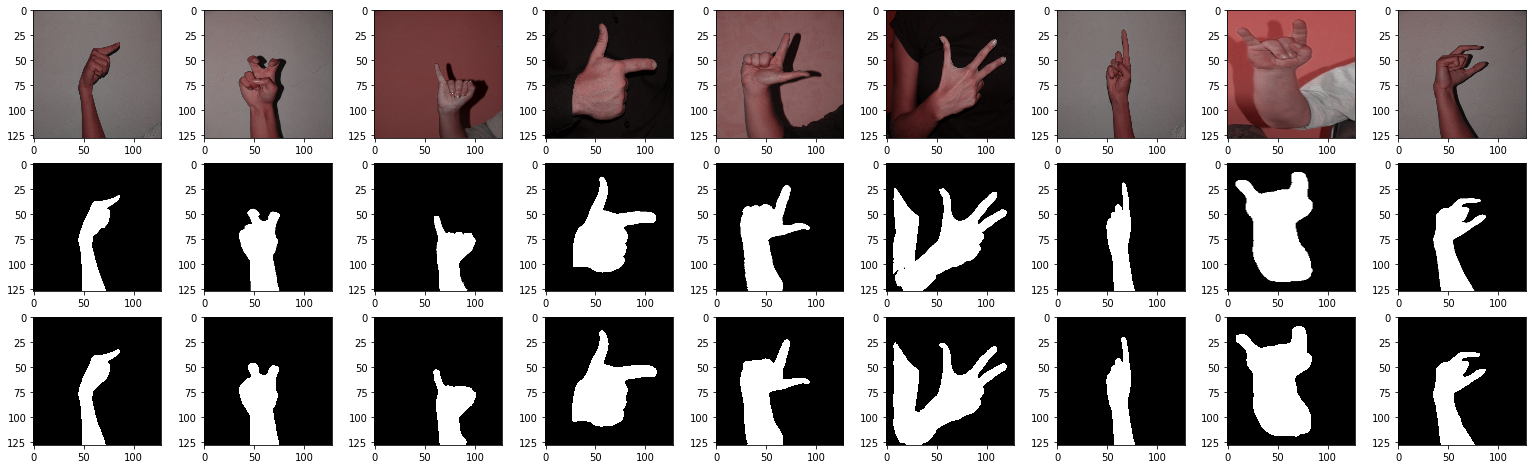

In [34]:
# Build a dashboard to see how the model performs on random examples

# Choose how many examples we want
k = 9

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=3, ncols=k, figsize=(3*k, 8))

sample = random.sample(range(len(y_test)), k)

preds = -1 * unet.predict(X_test[sample]) + 1

# Cycle through a random selection of k images
for i, j in enumerate(sample):

  example_img = X_test[j]
  example_mask = y_test[j]

  # Feed the images through the model
  pred_mask_ex = (preds[i] > 0.4)

  # Reshape the output back to a 2-D image format
  pred_mask_ex = pred_mask_ex.reshape((128, 128))

  # Show the original image, predicted map and ground truth map
  ax[0, i].imshow(cv.cvtColor(example_img,cv.COLOR_HSV2RGB))
  ax[1, i].imshow((-1*example_mask+1))
  ax[2, i].imshow(pred_mask_ex, cmap='gray')

<H1> Comparing results

In [35]:
# Speed comparison

k = 500

# Take a random sample of 500 images
speed_sample = random.sample(range(len(X)), k)

# Function predicting a sample of images for Logistic Regression
def time_log_reg(sample):
  flat = X[sample].reshape((-1, 3))
  pred = model_lr.predict(flat)

  pred = pred.reshape((-1, 128, 128))

# Function predicting a sample of images for Autoencoder 
def time_autoencoder(sample):
  sample_im = X[sample]

  autoencoder.predict(sample_im)

# Function predicting a sample of images for UNET
def time_unet(sample):
  sample_im = X[sample]

  unet.predict(sample_im)


%timeit -n25 time_log_reg(speed_sample)

%timeit -n25 time_autoencoder(speed_sample)

%timeit -n25 time_unet(speed_sample)

25 loops, best of 5: 158 ms per loop
25 loops, best of 5: 353 ms per loop
25 loops, best of 5: 420 ms per loop


In [36]:
log_reg_times = []
auto_times = []
unet_times = []

for i in tqdm(range(300)):

  speed_sample = random.sample(range(len(X)), 100)

  start_log = time()
  time_log_reg(speed_sample)
  end_log = time()

  log_reg_times.append((end_log - start_log)*1000)

  start_auto = time()
  time_autoencoder(speed_sample)
  end_auto = time()

  auto_times.append((end_auto - start_auto)*1000)

  start_unet = time()
  time_unet(speed_sample)
  end_unet = time()

  unet_times.append((end_unet - start_unet)*1000)

100%|██████████| 300/300 [01:29<00:00,  3.35it/s]


In [37]:
hist_lists = [log_reg_times, auto_times, unet_times]

In [43]:
for i in range(3):
  hist_lists[i] = np.array(hist_lists[i])
  hist_lists[i] = hist_lists[i][hist_lists[i] < 250]

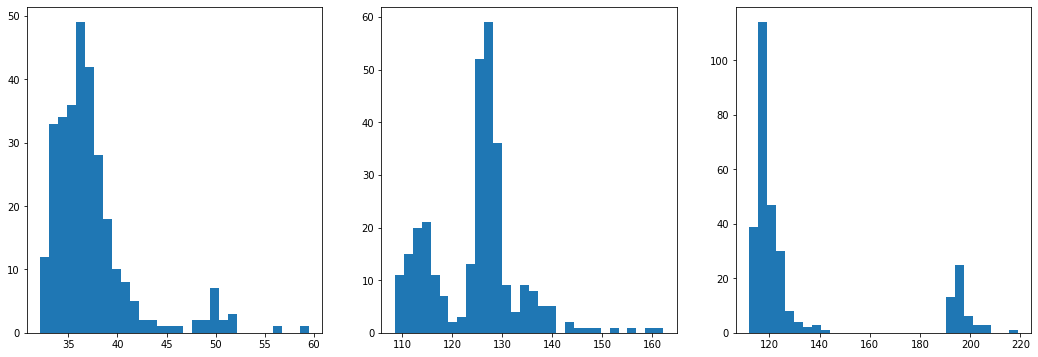

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, axis in enumerate(ax):
  axis.hist(hist_lists[i], bins=30)

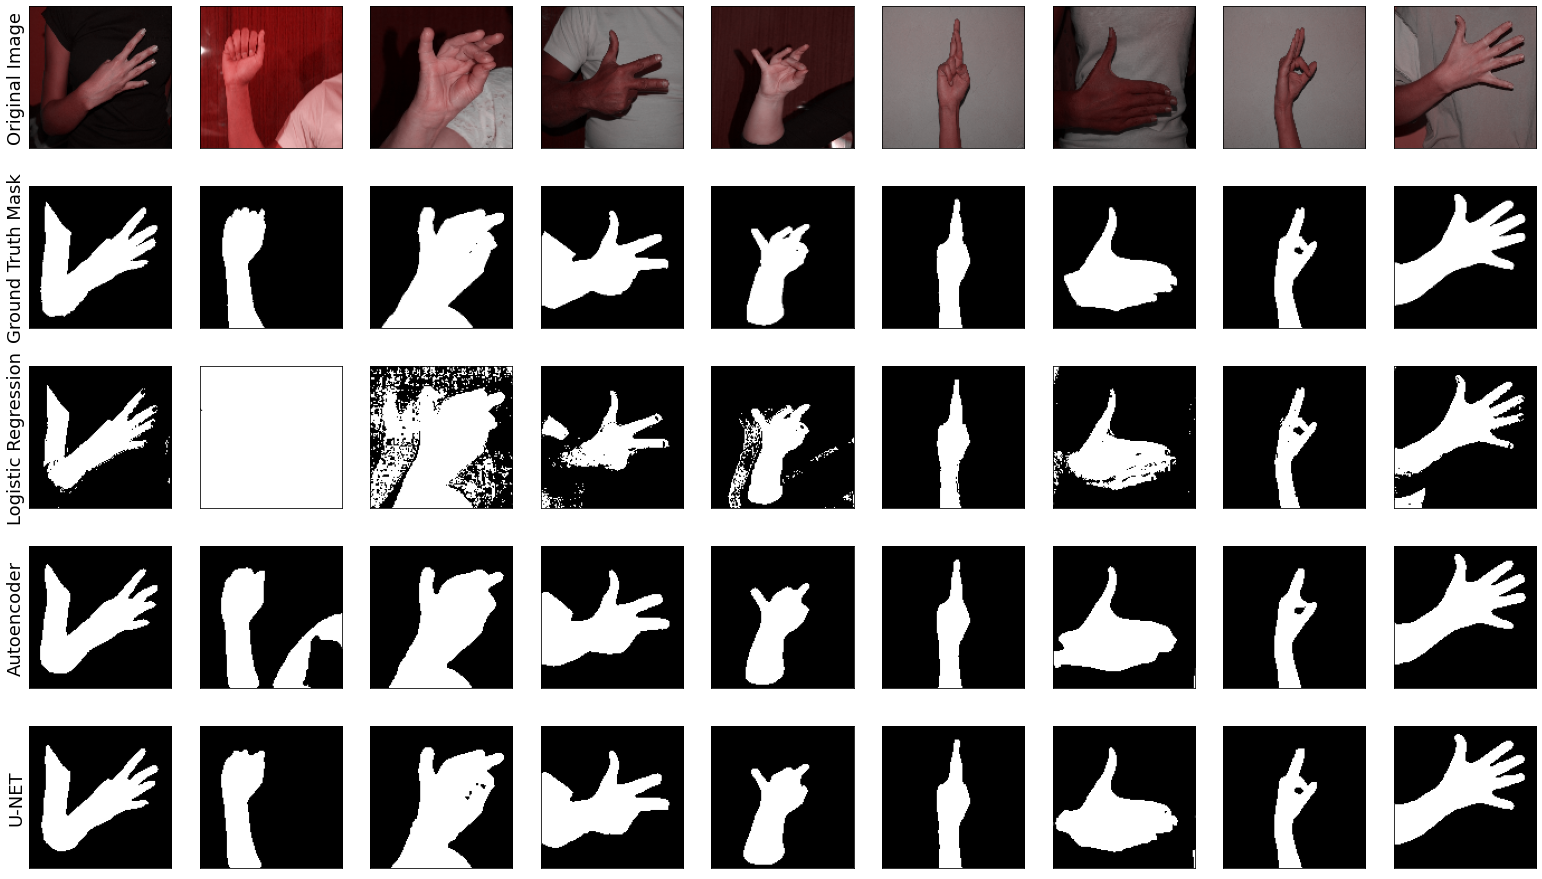

In [39]:
# Build a dashboard to compare model performance on random examples

# Choose how many examples we want
k = 9
labels = ['Original Image', 'Ground Truth Mask', 'Logistic Regression', 'Autoencoder', "U-NET"]

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=5, ncols=k, figsize=(3*k, 16))

for axis in ax.flatten():
  axis.set_xticklabels([], fontdict=None, minor=False)
  axis.set_xticks(ticks=[])

  axis.set_yticklabels([], fontdict=None, minor=False)
  axis.set_yticks(ticks=[])

sample = random.sample(range(len(y_test)), k)

preds_unet = (-1 * unet.predict(X_test[sample]) + 1) > 0.4

preds_auto = (-1 * autoencoder.predict(X_test[sample]) + 1) > 0.4

flat = X_test[sample].reshape((-1, 3))
preds_logreg = model_lr.predict(flat)

preds_logreg = preds_logreg.reshape((-1, 128, 128)) > 0.6

for i in range(5):
    ax[i, 0].set_ylabel(labels[i], fontsize=18)

# Cycle through a random selection of k images
for i, j in enumerate(sample):

  example_img = X_test[j]
  example_mask = y_test[j]

  unet_mask = preds_unet[i].reshape((128, 128))

  auto_mask = preds_auto[i].reshape((128, 128))

  logreg_mask = preds_logreg[i].reshape((128, 128))

  # Show the original image, predicted map and ground truth map
  ax[0, i].imshow(cv.cvtColor(example_img,cv.COLOR_HSV2RGB))
  ax[1, i].imshow((-1*example_mask+1))
  ax[2, i].imshow(logreg_mask, cmap='gray')
  ax[3, i].imshow(auto_mask, cmap='gray')
  ax[4, i].imshow(unet_mask, cmap='gray')

In [40]:
unet.save('unet.h5')

<H1> Results and Review

To review the results we have to consider the following aspects: Time and Accuracy.

1. Time - timewise, we have no surprises. We can clearly see that Logistic Regression is often 2-3 times faster than the other methods. Autoencoder and UNET have very similar distributions, however UNET has a small bump in higher processing times.

2. Accuracy - Here we can clearly see that Logistic Regression is unfit for many purposes. It easily mixes up background and hands, which can lead to many issues in usage of the segmentation map. Autoencoder and UNET have very similar results. However, we can see that UNET has slightly better defined edges and fingers, giving it a slight edge.

Overall, it is easy to see that all three methods can be used in real-time applications, because their processing times are well below 30 ms per frame (needed for processing 30fps videos). Keeping this and the accuracy results in mind, it is evident that UNET is the best architecture to proceed with this job as it provides superior accuracy, segmentation quality and comparable speed.
